<a href="https://colab.research.google.com/github/emrapport/w266-final-project/blob/master/final_model_error_analysis_LP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Error analysis of final model



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time
import pickle
!pip install gcsfs

pd.set_option('max_colwidth', 100)

In [3]:
# this cell is only necessary if running in colab
project_id = 'w266-251323'
import uuid
bucket_name = 'fb-congressional-data/'
from google.colab import auth
auth.authenticate_user()
!gcloud config set project {project_id}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Updated property [core/project].


In [4]:
# Load the test data and predictions
test_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/test.csv", index_col=0)
test_preds = pd.read_csv("gs://fb-congressional-data/models/test_preds.csv")
test_preds_party = pd.read_csv("gs://fb-congressional-data/models/test_preds_party.csv")


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
# Load the dev data and predictions
dev_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/dev.csv", index_col=0)
dev_preds = pd.read_csv("gs://fb-congressional-data/models/dev_preds.csv")
dev_preds_party = pd.read_csv("gs://fb-congressional-data/models/dev_preds_party.csv")


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
test_preds.head()

,original_idx,probs,preds
0,9225551,0.398534,M
1,7514285,0.363646,M
2,6128273,0.283775,M
3,6370382,0.320124,M
4,8962461,0.316799,M


In [0]:
test_preds_party.head()

,original_idx,probs_party,preds_party
0,9225551,0.384233,Congress_Republican
1,7514285,0.545365,Congress_Democrat
2,6128273,0.400835,Congress_Republican
3,6370382,0.327347,Congress_Republican
4,8962461,0.461587,Congress_Republican


In [0]:
# dev_preds.head()

,original_idx,probs,preds
0,2210805,0.288363,M
1,10316428,0.253759,M
2,5297343,0.252464,M
3,5030266,0.293893,M
4,4918178,0.176300,M


In [0]:
# dev_preds_party.head()


,original_idx,probs_party,preds_party
0,2210805,0.653872,Congress_Democrat
1,10316428,0.457214,Congress_Republican
2,5297343,0.353170,Congress_Republican
3,5030266,0.544343,Congress_Democrat
4,4918178,0.144020,Congress_Republican


In [0]:
# Correct the "democratic" party prediction to match op party 
# dev_preds_party.loc[dev_preds_party['preds_party']=='Congress_Democrat', 'preds_party'] = 'Congress_Democratic'
test_preds_party.loc[test_preds_party['preds_party']=='Congress_Democrat', 'preds_party'] = 'Congress_Democratic'


In [6]:
test_df = test_df.merge(test_preds,on='original_idx')
test_df = test_df.merge(test_preds_party,on='original_idx')
test_df.head()

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
0,1682766,78379937,W,21367,Tonia,jacky thank you for addressing this very troubling news! please demand a full independent invest...,Jacky Rosen,Congress_Democratic,0.286659,M,0.567257,Congress_Democratic
1,1682767,78379937,W,21367,Michancy,agreed! the russian connection to this administration must be fully investigated. flynn is the ...,Jacky Rosen,Congress_Democratic,0.150482,M,0.439200,Congress_Republican
2,1682768,78379937,W,21367,Andrea,please push chaffez and cummings to look into this!,Jacky Rosen,Congress_Democratic,0.203123,M,0.508537,Congress_Democratic
3,1682769,78379937,W,21367,Tina,i could not agree more!,Jacky Rosen,Congress_Democratic,0.229004,M,0.370849,Congress_Republican
4,1682770,78379937,W,21368,Cathy,"i imagine that is followed by ""when qualifited.""",Jacky Rosen,Congress_Democratic,0.275994,M,0.354149,Congress_Republican


In [7]:
test_df[(test_df.response_text == "thank you, senator")]

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
124513,3002872,42138413,M,80444,Pat,"thank you, senator",Tim Scott,Congress_Republican,0.286767,M,0.652213,Congress_Democratic
148659,3028507,42138413,M,80796,Mary,"thank you, senator",Tim Scott,Congress_Republican,0.286767,M,0.652213,Congress_Democratic
152725,3032792,42138413,M,80837,Ginger,"thank you, senator",Tim Scott,Congress_Republican,0.286767,M,0.652213,Congress_Democratic
158848,3039513,42138413,M,80876,Laura,"thank you, senator",Tim Scott,Congress_Republican,0.286767,M,0.652213,Congress_Democratic
171999,3053659,42138413,M,81031,Dave,"thank you, senator",Tim Scott,Congress_Republican,0.286767,M,0.652213,Congress_Democratic
217860,3101669,42138413,M,81698,Dave,"thank you, senator",Tim Scott,Congress_Republican,0.286767,M,0.652213,Congress_Democratic
218995,3102828,42138413,M,81701,Kim,"thank you, senator",Tim Scott,Congress_Republican,0.286767,M,0.652213,Congress_Democratic
222449,3106375,42138413,M,81743,Michael,"thank you, senator",Tim Scott,Congress_Republican,0.286767,M,0.652213,Congress_Democratic
269183,3497224,33093506,W,114275,Brian,"thank you, senator",Tammy Baldwin,Congress_Democratic,0.286767,M,0.652213,Congress_Democratic
269515,3497565,33093506,W,114278,Brian,"thank you, senator",Tammy Baldwin,Congress_Democratic,0.286767,M,0.652213,Congress_Democratic


In [11]:
train_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/train.csv", index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
train_df[(train_df.response_text == "thank you, senator") & (train_df.op_name == "Kamala Harris")]


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category
4778763,6462049,7212873,W,246284,Ted,"thank you, senator",Kamala Harris,Congress_Democratic
4803162,6486448,7212873,W,246368,Chris,"thank you, senator",Kamala Harris,Congress_Democratic
4806537,6489823,7212873,W,246390,Albert,"thank you, senator",Kamala Harris,Congress_Democratic
4813043,6496329,7212873,W,246425,Rupert,"thank you, senator",Kamala Harris,Congress_Democratic


In [0]:
EW_thankyou = train_df[(train_df.response_text == "thank you") & (train_df.op_name == "Elizabeth Warren")]
EW_thankyou_list = EW_thankyou['post_id'].value_counts()

In [17]:
EW_thankyou_list

300942    52
300708    44
301143    24
300727    16
300807    14
          ..
300922     1
300927     1
300928     1
300931     1
301058     1
Name: post_id, Length: 174, dtype: int64

In [0]:
# dev_df = dev_df.merge(dev_preds,on='original_idx')
# dev_df = dev_df.merge(dev_preds_party,on='original_idx')
# dev_df.head()

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
0,1965080,86681682,M,29909,James,thanks for passing this ridiculous legislation. https://www.youtube.com/watch?v=-y4wd8royre,Jim Banks,Congress_Republican,0.208421,M,0.391387,Congress_Republican
1,1965081,86681682,M,29909,Martha,handsome young man on the left. 😂 mom,Jim Banks,Congress_Republican,0.257950,M,0.436190,Congress_Republican
2,1965082,86681682,M,29911,Preston,you are sideways!,Jim Banks,Congress_Republican,0.364659,M,0.484376,Congress_Republican
3,1965083,86681682,M,29911,Bobby,hi congressman banks,Jim Banks,Congress_Republican,0.035806,M,0.493345,Congress_Republican
4,1965084,86681682,M,29911,Landon,"jim, i love your office. the 5th floor is for winners.",Jim Banks,Congress_Republican,0.048077,M,0.546275,Congress_Democrat


In [0]:
wrong_preds = test_df[test_df.op_gender!=test_df.preds]


In [0]:
wrong_preds.op_gender.value_counts()

W    219299
M     57502
Name: op_gender, dtype: int64

In [0]:
# total proportion of preds for women
dev_df.preds.value_counts()['W'] / len(dev_df)

0.03995132955674003

In [0]:
#random sample of mistakes
wrong_preds.sample(10)

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
72927,2334550,98470558,W,50405,Stephen,what about balancing the budget? if we are going behind because of the aca or other our of cont...,Elise Stefanik,Congress_Republican,0.203921,M,0.175891,Congress_Republican
1391124,13695667,83604908,W,534889,B.,win baby!,Shelley Moore Capito,Congress_Republican,0.332606,M,0.323022,Congress_Republican
1384380,13688555,83604908,W,534736,Diane,shelley i am torn apart with our pres. having thousands of foreign soljors here from the un. and...,Shelley Moore Capito,Congress_Republican,0.189369,M,0.318477,Congress_Republican
446420,6344060,67504140,M,233336,Keith,"kay hagan has been nothing more than obama's rubber stamp since 2009. now, she expects people to...",Thom Tillis,Congress_Republican,0.548123,W,0.122853,Congress_Republican
705432,8911098,3162230,W,305345,Tim,just my luck. streaming cut out and i missed all but the last 2 minutes but from what i did hear...,Kristi Noem,Congress_Republican,0.266814,M,0.312440,Congress_Republican
313436,4126921,72264613,W,147923,Efrem,"if i were to give that answer, i would say yes (channeling winston zeddmore from ghostbusters) t...",Kyrsten Sinema,Congress_Democratic,0.227072,M,0.311274,Congress_Republican
306694,4119675,72264613,W,147644,Tim,when/where is your next book signing?,Kyrsten Sinema,Congress_Democratic,0.298402,M,0.438716,Congress_Republican
632984,7606969,47811014,W,292574,Jaye,welcome back. I am glad you got the help you needed hopefully more will get back to their families.,Chellie Pingree,Congress_Democratic,0.345052,M,0.502120,Congress_Democrat
341861,5801475,62031614,W,191604,Randy,repeal times 17 trillion,Jackie Walorski,Congress_Republican,0.186514,M,0.147731,Congress_Republican
273379,3501547,33093506,W,114380,Dianne,http://indiancountrytodaymedianetwork.com/2016/11/27/after-month-conflict-mass-media-arrives-for...,Tammy Baldwin,Congress_Democratic,0.298474,M,0.446861,Congress_Republican


In [0]:
# most confident wrong predictions where true was M but prediction was W
wrong_preds.sort_values('probs', ascending=False)[:20]

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
362434,6096572,39064513,M,209578,Sue,"thank you, bernie. thank you, jill. thank you, tulsi. thank you to all the veterans. and a s...",Earl Blumenauer,Congress_Democratic,0.999994,W,0.999999,Congress_Democrat
933902,9321039,61839194,M,327804,Kenneth,"hey kamala, i voted for you because of the great work you have done for the environmental justic...",Cory Booker,Congress_Democratic,0.999930,W,0.999951,Congress_Democrat
933563,9320679,61839194,M,327804,Judy,go kamala. win!,Cory Booker,Congress_Democratic,0.999873,W,0.999685,Congress_Democrat
933715,9320844,61839194,M,327804,Kristina,i love and appreciate all three of you! kamala has all five of our votes!!👍,Cory Booker,Congress_Democratic,0.999848,W,0.999400,Congress_Democrat
381625,6116832,39064513,M,210160,Claudia,what is tulsi doing in portland ? she is hawaii's congresswoman. doing a wonderful job.,Earl Blumenauer,Congress_Democratic,0.999845,W,0.999877,Congress_Democrat
860437,9240975,61839194,M,327395,Cindy,thank you patty murray. i knew i voted for you for a good reason.,Cory Booker,Congress_Democratic,0.999827,W,0.999934,Congress_Democrat
933860,9320995,61839194,M,327804,Lynn,kamala will be a most wonderful addition to the us senate..heart thanks for hair support...💌,Cory Booker,Congress_Democratic,0.999814,W,0.999936,Congress_Democrat
926925,9313361,61839194,M,327789,Ralph,"good job corey, better job patty for keeping your hand on the pulse of america.",Cory Booker,Congress_Democratic,0.999745,W,0.994470,Congress_Democrat
857375,9237795,61839194,M,327395,Ann,i <3 patty murray. and you. thank you. i <3 wa state.,Cory Booker,Congress_Democratic,0.999650,W,0.999497,Congress_Democrat
933573,9320689,61839194,M,327804,John,"stay close to them, kamala--that has the future.",Cory Booker,Congress_Democratic,0.999585,W,0.999484,Congress_Democrat


In [0]:
# most confident wrong predictions where true was W but predicted M
wrong_preds.sort_values('probs', ascending=True)[:20]

,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
633199,7607197,47811014,W,292581,Mark,if angus votes for him angus will lose my vote next cycle.,Chellie Pingree,Congress_Democratic,0.000052,M,0.196593,Congress_Republican
667404,8871902,3162230,W,303890,Joelle,vote gohmert! and remember you are there for america not just sd. very disappointed you voted fo...,Kristi Noem,Congress_Republican,0.000072,M,0.000129,Congress_Republican
75588,2337351,98470558,W,50839,Katie,go louie :),Elise Stefanik,Congress_Republican,0.000078,M,0.000933,Congress_Republican
681997,8887071,3162230,W,304367,Carl,it would seem you are an old hand at dealing with clowns like that. keep up the good fight sir!,Kristi Noem,Congress_Republican,0.000106,M,0.162795,Congress_Republican
638638,7612806,47811014,W,292642,Kathy,we must be sure to let rep. poliquin know that we are watching how he votes on this.,Chellie Pingree,Congress_Democratic,0.000146,M,0.000494,Congress_Republican
638455,7612619,47811014,W,292641,Ren,"so, just wondering is rep poliquin going to vote against obama care and strip 75,000 mainers fr...",Chellie Pingree,Congress_Democratic,0.000174,M,0.005336,Congress_Republican
353324,5928285,15083367,W,201408,Heather,"you do realize you only won by 5.8 %. start doing your job, show up and listen to your constitue...",Barbara Comstock,Congress_Republican,0.000281,M,0.000075,Congress_Republican
642983,7617345,47811014,W,292986,Sam,"sending good thoughts, angus!",Chellie Pingree,Congress_Democratic,0.000307,M,0.106553,Congress_Republican
289660,4101545,72264613,W,146140,Don,"what a phony you are! I am so proud of my rep, ruben gallego.",Kyrsten Sinema,Congress_Democratic,0.000354,M,0.998451,Congress_Democrat
1391273,13695821,83604908,W,534896,Susie,"tennant out this time, carper out the next time. shelley has my vote. jim ballard",Shelley Moore Capito,Congress_Republican,0.000362,M,0.961506,Congress_Democrat


In [0]:
# Least confident predictions.

least_conf = test_df[(test_df.probs<0.50005) & (test_df.probs>0.49995)]

In [0]:
# Incorrect low confidence predictions.
least_conf[least_conf.op_gender!=least_conf.preds].sort_values(by='probs')


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
339155,5797921,62031614,W,191300,Jen,seriously? unemployment is at 5% and the stock market is still at a all time high .... actions a...,Jackie Walorski,Congress_Republican,0.499951,M,0.431080,Congress_Republican
296202,4108647,72264613,W,146797,Michael,it must be an election year. the prada socialist ( her words) claiming to be for the good sheepl...,Kyrsten Sinema,Congress_Democratic,0.499955,M,0.255204,Congress_Republican
290034,4101964,72264613,W,146192,William,"omg, I am agreeing with ms. sinema.",Kyrsten Sinema,Congress_Democratic,0.499982,M,0.652048,Congress_Democrat
860607,9241152,61839194,M,327395,Ann,some are so hung up on the abortion issue that they ignore all the other issues of women's health,Cory Booker,Congress_Democratic,0.500004,W,0.514635,Congress_Democrat
1413104,13822951,8879946,M,540664,Kristen,what if the breast cancer patient is on medicaid?,Bill Cassidy,Congress_Republican,0.500011,W,0.554036,Congress_Democrat
423770,6320227,67504140,M,233105,Kesha,hagan knows we all now how she misused that stimulus for her personal use! crime,Thom Tillis,Congress_Republican,0.500014,W,0.354412,Congress_Republican
214771,3098496,42138413,M,81676,Loretta,we need more senators like you. wish you were here in florida,Tim Scott,Congress_Republican,0.500020,W,0.579296,Congress_Democrat
975392,10019419,41098373,M,364679,Kerry,i am proud that my congressional representative dwight evans joined john lewis and others in boy...,Dwight Evans,Congress_Democratic,0.500020,W,0.992244,Congress_Democrat
984541,11114055,10284504,M,391015,Carol,proud of our west salem girl!,Ron Kind,Congress_Democratic,0.500041,W,0.464439,Congress_Republican
1162129,12270735,18759563,M,458809,Milton,"actually, tom cotton did not violate the logan act which applies to private citizens negotiating...",Tom Cotton,Congress_Republican,0.500043,W,0.624831,Congress_Democrat


In [0]:
# Correct low confidence predictions.
least_conf[least_conf.op_gender==least_conf.preds].sort_values(by='probs')


,original_idx,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category,probs,preds,probs_party,preds_party
165660,3046932,42138413,M,80946,Brigitte,"happy mother's day to your mother, a strong woman!",Tim Scott,Congress_Republican,0.499951,M,0.648575,Congress_Democrat
784959,9160751,61839194,M,327345,Nicky,"as the parent of an amazing daughter with special needs, i want to thank you from the bottom of ...",Cory Booker,Congress_Democratic,0.499951,M,0.586767,Congress_Democrat
360042,6094104,39064513,M,209554,Jeannette,"thank you for your words about the hero john lewis. and, for your stand in boycotting the inaugu...",Earl Blumenauer,Congress_Democratic,0.499961,M,0.996039,Congress_Democrat
774333,9149525,61839194,M,327340,Giselle,"thank you for calling this out, senator booker! she had the right to read this letter!",Cory Booker,Congress_Democratic,0.499963,M,0.598405,Congress_Democrat
783367,9159119,61839194,M,327342,Betty,yeah well i am still deeply upset that you sold out to pharma...,Cory Booker,Congress_Democratic,0.499965,M,0.744950,Congress_Democrat
182677,3064882,42138413,M,81170,Betty,what fine men their mother did something great when she raised them.,Tim Scott,Congress_Republican,0.499965,M,0.385799,Congress_Republican
543695,7484818,65473098,M,288121,Jonn,"we tried and look what they did to us in michigan to keep it off the ballot,sorry but we should ...",Thomas Massie,Congress_Republican,0.499984,M,0.566431,Congress_Democrat
431961,6328802,67504140,M,233157,BillandKay,yes let us move her out,Thom Tillis,Congress_Republican,0.499986,M,0.324856,Congress_Republican
421992,6318375,67504140,M,233095,John,what would she do if thom tillis walked in? run and hide again?,Thom Tillis,Congress_Republican,0.499987,M,0.301572,Congress_Republican
104725,2981803,42138413,M,80121,Roseanne,"i am a south carolinian and a retired professor, educated through the public school system. bets...",Tim Scott,Congress_Republican,0.499988,M,0.290688,Congress_Republican


In [0]:
get_short_response(test_df.iloc[324826]['response_text'])

'it has not limited to bathrooms, if a male student feels like a female today and wants to reside in an all girl dorm on college campus, they have to admit him .'

In [0]:
test_df.iloc[296202]['response_text']


'it must be an election year. the prada socialist ( her words) claiming to be for the good sheeple of arizona. remember she was the point person for the affordable care act. a broken clock is accurate twice a day. a rubber stamp for the enslavement of america.'

In [0]:
test_df.iloc[975392]['response_text']


'i am proud that my congressional representative dwight evans joined john lewis and others in boycotting the inauguration.  we stand behind you!'

In [0]:
test_df.iloc[1162129]['response_text']

'actually, tom cotton did not violate the logan act which applies to private citizens negotiating with foreign leaders. he sent a one-way letter, no response necessary, to iran as a disclaimer so they would know what our constitutional laws involve. to be accurate though, the logan act has been violated in the past: in 1985 democratic senators john kerry and tom harkin flew to the communist country of nicaragua and negotiated with nicaraguan dictator daniel ortega behind president reagan\'s back. "kerry, in office only a few months and with no consultation with the administration or the state department, decided to negotiate with ortega. he and harkin walked away from nicaragua with an agreement for direct talks with washington. president reagan flatly rejected it." http://www.wnd.com/2004/02/23312/  in 2007 democratic house speaker nancy pelosi challenged the white house on middle east policy, meeting with syria\'s leader assad despite bush objections. "the bush administration has rej

In [0]:
def get_short_response(response,length=40):
  '''Take a string of words strings and a goal max length. Return the goal length list
  taken half from the beginning of the orginal list and half from the end of 
  the original list.'''
  split_response = response.split()
  if len(split_response) > length:    
    new_response = split_response[:length//2] + split_response[-length//2:]
    return ' '.join(new_response)
  else:
    return response


In [0]:
# This one has boy and she
get_short_response(test_df.iloc[429644]['response_text'])

'boy sorry i was not able to see this.. in military terms she sounds like she boloed (failed) it. i am sooooo glad.'

In [25]:
test_df.probs.mean()

0.24300776406648333

average probability for responses with this word: 0.2896755143257358
proportion of responses that have this word: 0.00085

\bsweet\b
count    1360.000000
mean        0.289676
std         0.140811
min         0.000799
25%         0.212319
50%         0.288061
75%         0.354634
max         0.999801
Name: probs, dtype: float64
proportion of subset of responses where we predict W: 0.052
proportion of subest of responses labeled W: 0.204

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053
proportion of responses labeled W: 0.172

how often model gets it wrong when sweet is present: 0.225
how often model gets it wrong overall: 0.178


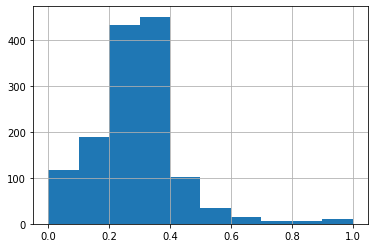

In [33]:
def analyze_word(my_word):
  print_word = my_word
  word = r"\b{}\b".format(print_word)
  word_preds = test_df[test_df['response_text'].str.contains(word)]
  word_preds.probs.hist()
  print("average probability for responses with this word:",word_preds.probs.mean())
  print("proportion of responses that have this word: {:.5f}".format(word_preds.shape[0] / test_preds.shape[0]))
  print("\n{}".format(word))
  print(word_preds.probs.describe())
  print("proportion of subset of responses where we predict W: {:.3f}".format(word_preds[word_preds.preds=='W'].shape[0] / word_preds.shape[0]))
  print("proportion of subest of responses labeled W: {:.3f}".format(word_preds[word_preds.op_gender=='W'].shape[0] / word_preds.shape[0]))
  print("\noverall")
  print(test_df.probs.describe())
  word_wrong_preds = word_preds[word_preds.op_gender!=word_preds.preds]
  print("proportion of responses where we predict W: {:.3f}".format(test_preds[test_preds.preds=='W'].shape[0] / test_preds.shape[0]))
  print("proportion of responses labeled W: {:.3f}".format(test_df[test_df.op_gender=='W'].shape[0] / test_df.shape[0]))
  print("\nhow often model gets it wrong when {} is present: {:.3f}".format(print_word, word_wrong_preds.shape[0] / word_preds.shape[0]))
  print("how often model gets it wrong overall: {:.3f}".format(wrong_preds.shape[0] / test_df.shape[0]))
analyze_word("sweet")

average probability for responses with this word: 0.24619106167391508
proportion of responses that have this word: 0.00362

\bpretty\b
count    5773.000000
mean        0.246191
std         0.142399
min         0.000133
25%         0.176316
50%         0.233199
75%         0.291068
max         0.998891
Name: probs, dtype: float64
proportion of subset of responses where we predict W: 0.051
proportion of subest of responses labeled W: 0.223

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053
proportion of responses labeled W: 0.172

how often model gets it wrong when pretty is present: 0.218
how often model gets it wrong overall: 0.178


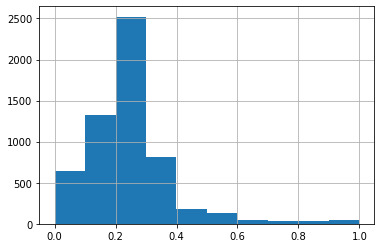

In [34]:
analyze_word("pretty")

proportion of responses that have this word: 0.00129

\bpowerful\b
count    2053.000000
mean        0.259083
std         0.156553
min         0.000010
25%         0.180599
50%         0.238771
75%         0.308138
max         0.999263
Name: probs, dtype: float64
proportion of responses where we predict W: 0.055

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when powerful is present: 0.168
how often model gets it wrong overall: 0.178


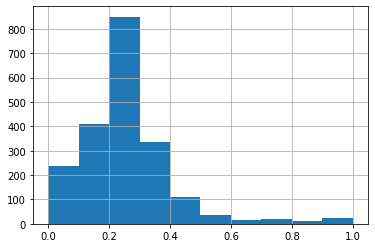

In [13]:
analyze_word("powerful")

average probability for responses with this word: 0.3291854683142857
proportion of responses that have this word: 0.00004

\bsexy\b
count    70.000000
mean      0.329185
std       0.201516
min       0.014076
25%       0.215968
50%       0.297423
75%       0.349463
max       0.990020
Name: probs, dtype: float64
proportion of subset of responses where we predict W: 0.143
proportion of subest of responses labeled W: 0.343

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053
proportion of responses labeled W: 0.172

how often model gets it wrong when sexy is present: 0.429
how often model gets it wrong overall: 0.178


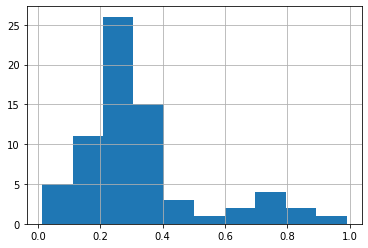

In [35]:
analyze_word("sexy")

proportion of responses that have this word: 0.01428

\bhappy\b
count    22787.000000
mean         0.260314
std          0.175402
min          0.000015
25%          0.166516
50%          0.266126
75%          0.316156
max          0.999874
Name: probs, dtype: float64
proportion of responses where we predict W: 0.063

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when happy is present: 0.242
how often model gets it wrong overall: 0.178


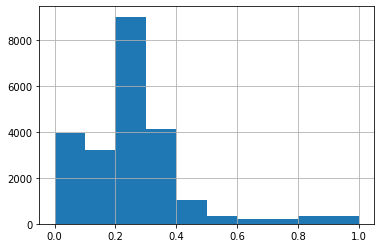

In [15]:
analyze_word("happy")

proportion of responses that have this word: 0.00682

\bnice\b
count    10893.000000
mean         0.263722
std          0.151362
min          0.000007
25%          0.183970
50%          0.258592
75%          0.328461
max          0.999729
Name: probs, dtype: float64
proportion of responses where we predict W: 0.049

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when nice is present: 0.246
how often model gets it wrong overall: 0.178


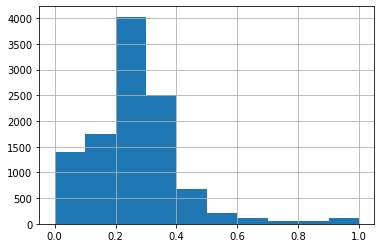

In [16]:
analyze_word("nice")

proportion of responses that have this word: 0.00512

\bguys\b
count    8175.000000
mean        0.166072
std         0.107653
min         0.000019
25%         0.108246
50%         0.154351
75%         0.206182
max         0.997938
Name: probs, dtype: float64
proportion of responses where we predict W: 0.017

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when guys is present: 0.151
how often model gets it wrong overall: 0.178


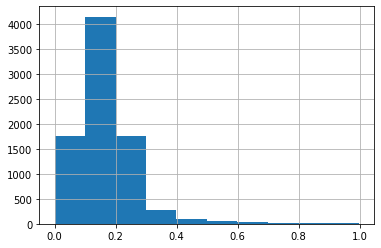

In [17]:
analyze_word("guys")

proportion of responses that have this word: 0.00032

\bnurse\b
count    515.000000
mean       0.295575
std        0.149568
min        0.003465
25%        0.218290
50%        0.287285
75%        0.356959
max        0.999821
Name: probs, dtype: float64
proportion of responses where we predict W: 0.078

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when nurse is present: 0.206
how often model gets it wrong overall: 0.178


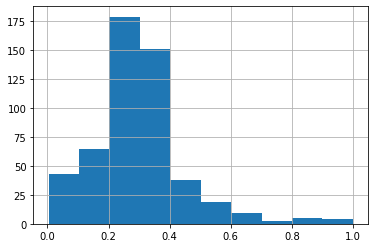

In [18]:
analyze_word("nurse")

proportion of responses that have this word: 0.00157

\bteacher\b
count    2504.000000
mean        0.277790
std         0.157918
min         0.000195
25%         0.190501
50%         0.275804
75%         0.345391
max         0.999071
Name: probs, dtype: float64
proportion of responses where we predict W: 0.073

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when teacher is present: 0.165
how often model gets it wrong overall: 0.178


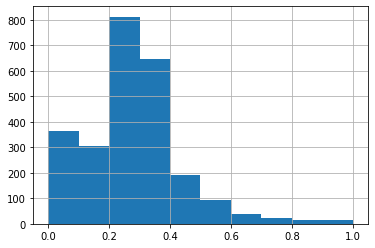

In [19]:
analyze_word("teacher")

proportion of responses that have this word: 0.00163

\bdoctor\b
count    2600.000000
mean        0.261656
std         0.133110
min         0.000524
25%         0.197044
50%         0.247346
75%         0.298799
max         0.997504
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when doctor is present: 0.205
how often model gets it wrong overall: 0.178


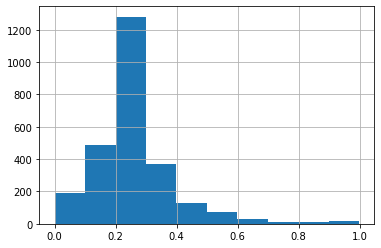

In [20]:
analyze_word("doctor")

proportion of responses that have this word: 0.00044

\blawyer\b
count    706.000000
mean       0.245225
std        0.165037
min        0.001306
25%        0.168225
50%        0.219862
75%        0.276047
max        0.980955
Name: probs, dtype: float64
proportion of responses where we predict W: 0.067

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when lawyer is present: 0.166
how often model gets it wrong overall: 0.178


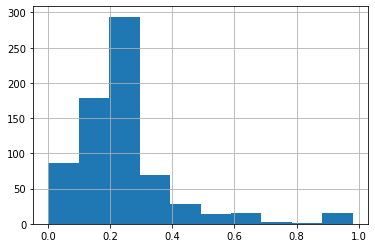

In [21]:
analyze_word("lawyer")

average probability for responses with this word: 0.2153721124680063
proportion of responses that have this word: 0.00057

\bsoldier\b
count    910.000000
mean       0.215372
std        0.113940
min        0.000046
25%        0.158235
50%        0.218481
75%        0.261450
max        0.983190
Name: probs, dtype: float64
proportion of subset of responses where we predict W: 0.022
proportion of subest of responses labeled W: 0.155

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053
proportion of responses labeled W: 0.172

how often model gets it wrong when soldier is present: 0.175
how often model gets it wrong overall: 0.178


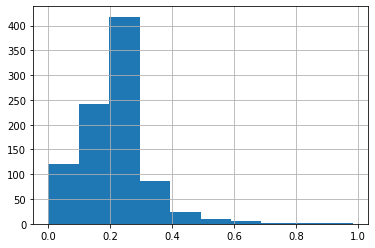

In [36]:
analyze_word("soldier")

proportion of responses that have this word: 0.00617

\bstrong\b
count    9854.000000
mean        0.240171
std         0.178933
min         0.000007
25%         0.139857
50%         0.227247
75%         0.299466
max         0.999994
Name: probs, dtype: float64
proportion of responses where we predict W: 0.065

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when strong is present: 0.163
how often model gets it wrong overall: 0.178


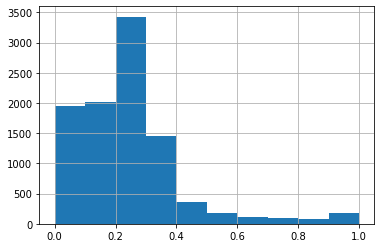

In [23]:
analyze_word("strong")

average probability for responses with this word: 0.25129773442077624
proportion of responses that have this word: 0.00219

\bsmart\b
count    3503.000000
mean        0.251298
std         0.171362
min         0.000314
25%         0.150618
50%         0.233580
75%         0.300298
max         0.995340
Name: probs, dtype: float64
proportion of subset of responses where we predict W: 0.080
proportion of subest of responses labeled W: 0.184

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053
proportion of responses labeled W: 0.172

how often model gets it wrong when smart is present: 0.195
how often model gets it wrong overall: 0.178


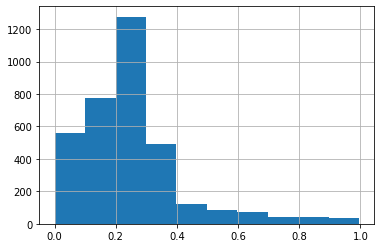

In [37]:
analyze_word("smart")

average probability for responses with this word: 0.4515680219134454
proportion of responses that have this word: 0.02306

\bshe\b
count    36811.000000
mean         0.451568
std          0.216034
min          0.000042
25%          0.295570
50%          0.449894
75%          0.583095
max          0.999845
Name: probs, dtype: float64
proportion of responses where we predict W: 0.396

overall
count    1.438596e+06
mean     2.430078e-01
std      1.440897e-01
min      1.281500e-06
25%      1.708394e-01
50%      2.336168e-01
75%      2.959621e-01
max      9.999936e-01
Name: probs, dtype: float64
proportion of responses where we predict W: 0.053

how often model gets it wrong when she is present: 0.379
how often model gets it wrong overall: 0.178


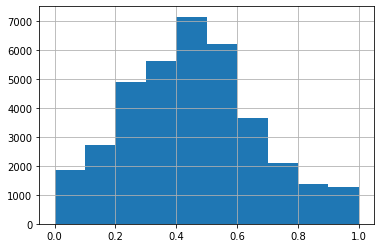

In [29]:
analyze_word("she")